# Overview of sktime's functionalities for forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
    ForecastingPipeline,
    DirectTabularRegressionForecaster
)
from sktime.forecasting.model_selection import (
    SlidingWindowSplitter,
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    ForecastingRandomizedSearchCV)
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MedianAbsolutePercentageError,
    median_absolute_percentage_error,
    make_forecasting_scorer,
    MeanAbsolutePercentageError)
from sktime.utils.plotting import plot_series

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set(rc={'figure.figsize':(12,6)})

### Importing data

In [4]:
df = sm.datasets.macrodata.load_pandas()['data']

In [5]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Data overview

Dataset contains USA quarterly macroeconomic data between 1959 and 2009. 

**Target variable - `realgdp`**

In [6]:
df['q_date'] = df.apply(lambda x: str(int(x['year'])) + "-" + 'Q'+ str(int(x['quarter'])), axis=1)
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()

In [7]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,q_date,date
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,1959-Q1,1959-01-01
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,1959-Q2,1959-04-01
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,1959-Q3,1959-07-01
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,1959-Q4,1959-10-01
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,1960-Q1,1960-01-01


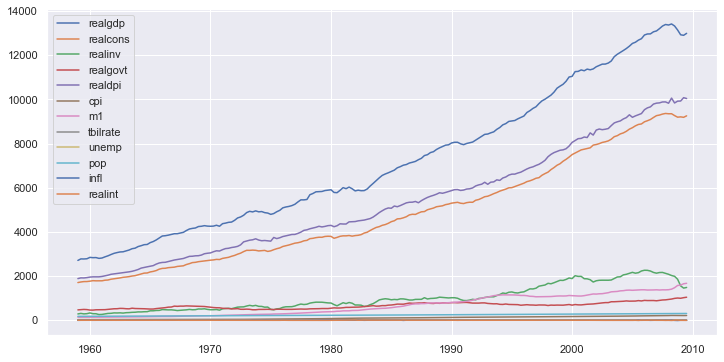

In [8]:
for val in df.columns[2:14]:
    plt.plot(df.date, df[val], label = val)
plt.legend();

In [9]:
df = df.set_index('date').to_period("Q")
df.index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203)

## 1. Unified API

### Basic forecasters interface

In [10]:
y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)

In [11]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=1) #forecasting one step ahead

In [12]:
y_pred

2002Q2    11477.868
Freq: Q-DEC, dtype: float64

### Forecasting horizons

In [13]:
fh_abs = ForecastingHorizon(y_test.index, is_relative=False) #specific data points
fh_abs

ForecastingHorizon(['2002Q2', '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3',
             '2003Q4', '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1',
             '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3',
             '2006Q4', '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1',
             '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', is_relative=False)

**Forecasts on the test set**

In [14]:
#cutoff is the last point in the training series
cutoff = pd.Period("2002-01-01", freq="Q")

#forecasting 1, 2, ..., 30 steps ahead of the last point in the training series
fh_rel = fh_abs.to_relative(cutoff)
fh_rel

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64', is_relative=True)

**In-sample forecasts**

In [15]:
#cutoff is 29 quarters after the last point in the training series
cutoff_insample = pd.Period("2009-09-01", freq="Q")

#forecasting 0, 1, ..., 29 steps before the last point in the training series
fh_rel_insample = fh_abs.to_relative(cutoff_insample)
fh_rel_insample

ForecastingHorizon([-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17,
            -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
             -3,  -2,  -1,   0],
           dtype='int64', is_relative=True)

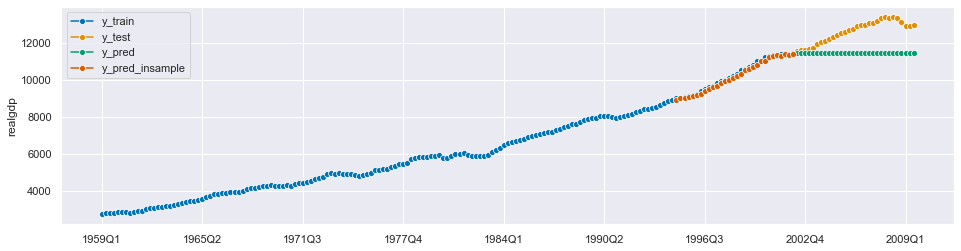

In [16]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_rel)
y_pred_insample = forecaster.predict(fh=fh_rel_insample)

plot_series(y_train, y_test, y_pred, y_pred_insample, labels=["y_train", "y_test", "y_pred", "y_pred_insample"]);

**Forward forecasts**

In [17]:
#cutoff is 12 quarters before the last point in the training series
cutoff_forward = pd.Period("1999-01-01", freq="Q")

#forecasting 13, 14, ..., 42 steps after the last point in the training series
fh_rel_forward = fh_abs.to_relative(cutoff_forward)
fh_rel_forward

ForecastingHorizon([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
            30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42],
           dtype='int64', is_relative=True)

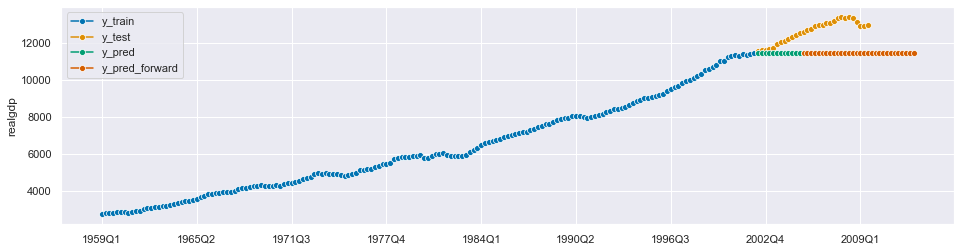

In [18]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_rel)
y_pred_forward = forecaster.predict(fh=fh_rel_forward)

plot_series(y_train, y_test, y_pred,y_pred_forward, labels=["y_train", "y_test", "y_pred", "y_pred_forward"]);

### Univariate time series

MASE: 2.864


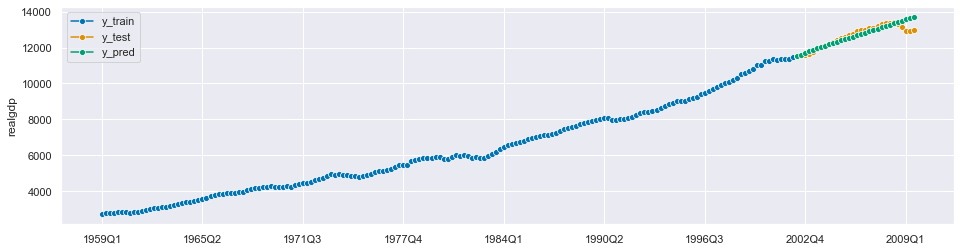

In [19]:
y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)

forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)

print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

MASE: 5.496


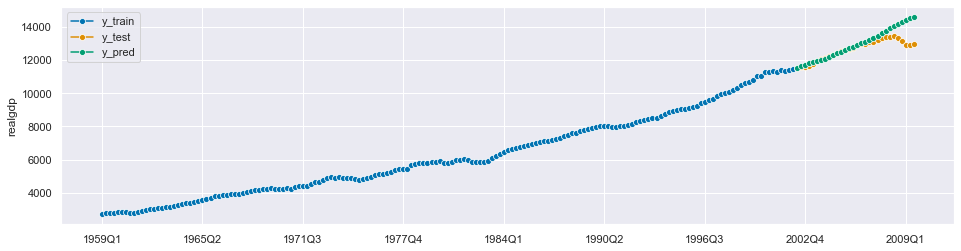

In [20]:
y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)

forecaster = DirectTabularRegressionForecaster(LinearRegression())
forecaster.fit(y_train, fh=fh_abs) #forecasting horizon necessary in the fit() method for this forecaster
y_pred = forecaster.predict()

print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Multivariate exogenous time series
Forecasting with exogenous variables (i.e. multivariate X)

In [21]:
#creating lagged values to avoid data leakage
df.loc[:, 'realinv_lagged'] = df.loc[:, 'realinv'].shift()
df[['realinv_lagged']] = df[['realinv_lagged']].fillna(method='backfill')

MASE: 6.708


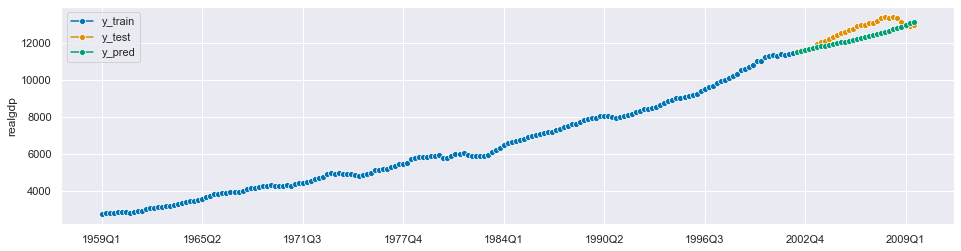

In [22]:
y = df['realgdp']
X = df[['realinv_lagged']] #could be more features
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh_abs)

forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(X=X_test, fh=fh_abs)

print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Updating a forecaster

In [23]:
y_old_data = y_train[:-4]
forecaster = AutoARIMA(sp=4)
forecaster.fit(y_old_data)
y_old_pred = forecaster.predict(fh_rel)

In [24]:
#updating the model with new data (full year) and generating predictions for the next period
y_new_data = y_train[-4:]
forecaster.update(y_new_data)
y_new_pred = forecaster.predict(fh_rel)

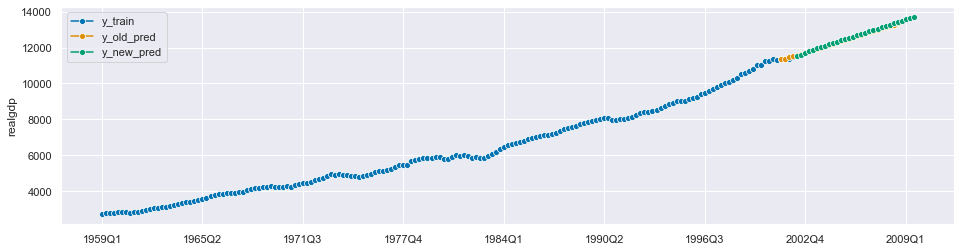

In [25]:
plot_series(y_train,  y_old_pred, y_new_pred, 
            labels=["y_train",  "y_old_pred", 'y_new_pred']);

## 2. Reducing a forecasting task to a regression problem

MASE: 4.104


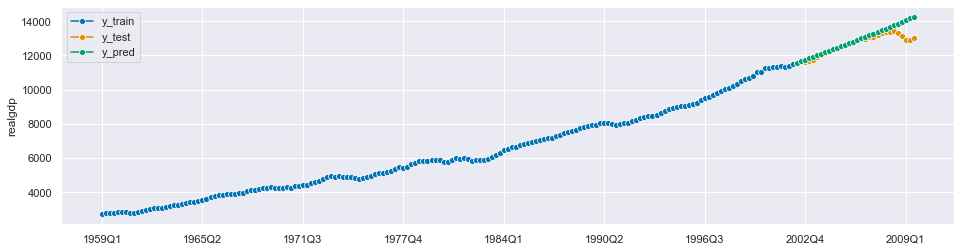

In [26]:
regressor = LinearRegression()
forecaster = make_reduction(estimator=regressor, strategy='recursive', window_length=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

MASE: 4.984


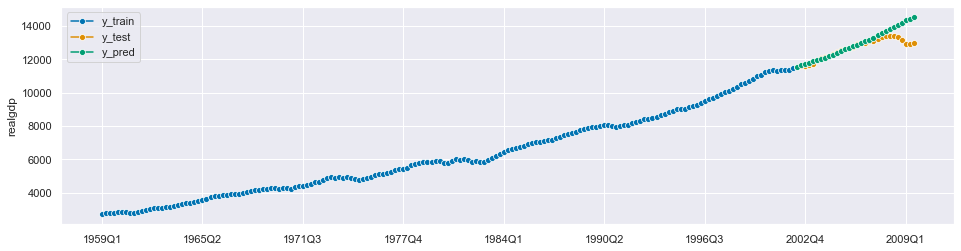

In [27]:
#direct reduction strategy
regressor = LinearRegression()
forecaster = DirectTabularRegressionForecaster(estimator=regressor, window_length=4)
forecaster.fit(y=y_train, fh=fh_abs)
y_pred = forecaster.predict()

print(f"MASE: {round(mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train), 3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## 3. Evaluation of forecasting models

### Performance metrics

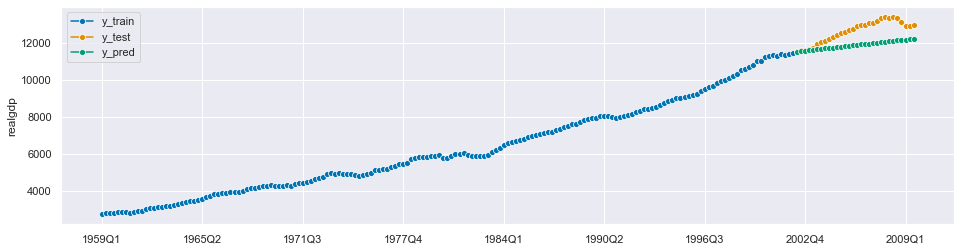

In [28]:
forecaster = ThetaForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [29]:
#MdAPE function
median_absolute_percentage_error(y_test, y_pred)

0.061994002943796644

In [30]:
#MdAPE class
mdape = MedianAbsolutePercentageError()
mdape(y_true=y_test, y_pred=y_pred)

0.061994002943796644

In [31]:
mdape.greater_is_better

False

In [32]:
#custom mape calculated on predictions with a ceiling
def custom_mape(y: np.array, y_hat: np.array, multioutput: str):
    metrics_dict = {'uniform_average': np.mean(np.abs((y - np.ceil(y_hat)) / y)),
                    'raw_values': np.abs((y - np.ceil(y_hat)) / y)}
    try:
        return metrics_dict[multioutput]
    except KeyError:
        print("multioutput not specified correctly - pick `raw_values` or `uniform_average`")

In [33]:
mape_changed = make_forecasting_scorer(func=custom_mape, multioutput = 'uniform_average')
mape_changed(y_test, y_pred)

0.05751249071487726

In [34]:
mape_changed = make_forecasting_scorer(func=custom_mape, multioutput = 'raw_values')
mape_changed(y_test, y_pred)

date
2002Q2    0.001020
2002Q3    0.003918
2002Q4    0.002054
2003Q1    0.004020
2003Q2    0.009772
2003Q3    0.024085
2003Q4    0.030792
2004Q1    0.035508
2004Q2    0.040349
2004Q3    0.045396
2004Q4    0.051593
2005Q1    0.059048
2005Q2    0.061135
2005Q3    0.066320
2005Q4    0.069160
2006Q1    0.079355
2006Q2    0.080807
2006Q3    0.079124
2006Q4    0.083968
2007Q1    0.084879
2007Q2    0.090198
2007Q3    0.096397
2007Q4    0.099337
2008Q1    0.095899
2008Q2    0.097297
2008Q3    0.089354
2008Q4    0.074869
2009Q1    0.057438
2009Q2    0.053831
2009Q3    0.058454
Freq: Q-DEC, dtype: float64

### Time-based cross-validation

- **Expanding Window**

In [35]:
forecaster = AutoARIMA(sp=4)
cv = ExpandingWindowSplitter(step_length=30, fh=list(range(1,31)), initial_window=40)
cv_df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True)

In [36]:
cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.026765,0.905093,0.005058,40,1968Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1969Q1 4244.100 1969Q2 4256.460 196...,1969Q1 4211.384583 1969Q2 4248.007673 19...
1,0.022689,1.289270,0.005054,70,1976Q2,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1976Q3 5154.072 1976Q4 5191.499 197...,1976Q3 5183.195991 1976Q4 5222.693347 19...
2,0.061730,0.880991,0.005413,100,1983Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1984Q1 6448.264 1984Q2 6559.594 198...,1984Q1 6385.598862 1984Q2 6428.366855 19...
3,0.051239,0.905481,0.004998,130,1991Q2,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1991Q3 8037.538 1991Q4 8069.046 1...,1991Q3 8048.706257 1991Q4 8090.890623 19...
4,0.009264,2.806351,0.003841,160,1998Q4,date 1959Q1 2710.349 1959Q2 2778.801 1...,date 1999Q1 10601.179 1999Q2 10684.049 1...,1999Q1 10623.174768 1999Q2 10727.402351 ...


Average MAPE with Expanding Window: 0.034


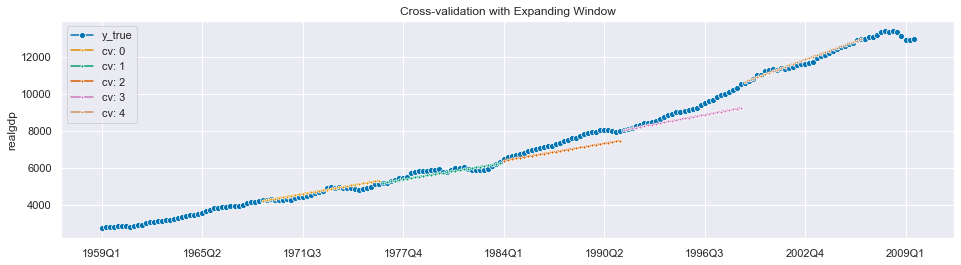

In [37]:
plot_series(
    y, *[cv_df["y_pred"].iloc[x] for x in range(5)],
    markers=["o", *["."]*5],
    labels=["y_true"] + [f"cv: {x}" for x in range(5)]
)
print(f"Average MAPE with Expanding Window: {round(cv_df['test_MeanAbsolutePercentageError'].mean(), 3)}")
plt.title('Cross-validation with Expanding Window');

- **Sliding Window**

In [38]:
forecaster = AutoARIMA(sp=4)
cv = SlidingWindowSplitter(step_length=30, fh=list(range(1,31)), initial_window=40)
cv_df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True)

In [39]:
cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.026765,0.891331,0.004931,40,1968Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1969Q1 4244.100 1969Q2 4256.460 196...,1969Q1 4211.384583 1969Q2 4248.007673 19...
1,0.031793,0.690039,0.005195,10,1976Q2,date 1974Q1 4909.617 1974Q2 4922.188 197...,date 1976Q3 5154.072 1976Q4 5191.499 197...,1976Q3 5178.306143 1976Q4 5227.665286 19...
2,0.017501,0.654600,0.005606,10,1983Q4,date 1981Q3 6030.184 1981Q4 5955.062 198...,date 1984Q1 6448.264 1984Q2 6559.594 198...,1984Q1 6386.849 1984Q2 6448.124 1984Q3 ...
3,0.011277,0.648825,0.004932,10,1991Q2,date 1989Q1 7806.603 1989Q2 7865.016 198...,date 1991Q3 8037.538 1991Q4 8069.046 1...,1991Q3 8080.539 1991Q4 8157.256 1992Q1...
4,0.050590,5.268004,0.003981,10,1998Q4,date 1996Q3 9488.879 1996Q4 9592.458 1...,date 1999Q1 10601.179 1999Q2 10684.049 1...,1999Q1 10749.932211 1999Q2 10780.149868 ...


Average MAPE with Sliding Window: 0.028


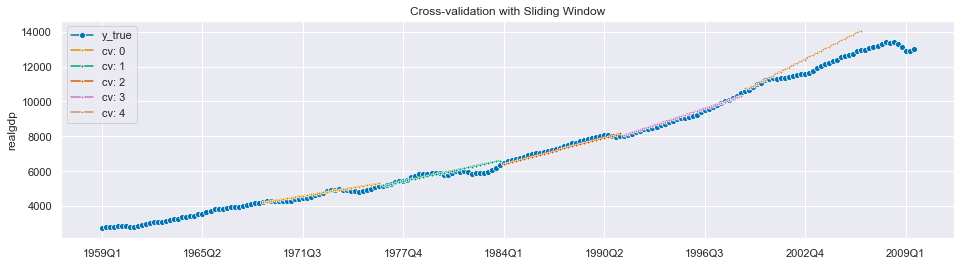

In [40]:
plot_series(
    y, *[cv_df["y_pred"].iloc[x] for x in range(5)],
    markers=["o", *["."]*5],
    labels=["y_true"] + [f"cv: {x}" for x in range(5)],
)
print(f"Average MAPE with Sliding Window: {round(cv_df['test_MeanAbsolutePercentageError'].mean(), 3)}")
plt.title('Cross-validation with Sliding Window');

### Tuning

- **Grid Search with a statistical model**

In [41]:
forecaster = AutoETS(sp=4, allow_multiplicative_trend=True)
params = {"trend": ["add", "mul"], 
          "damped_trend": [True, False]}

In [42]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
fgs = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=params)

In [43]:
fgs.fit(y_train)
y_pred = fgs.predict(fh_abs)

In [44]:
fgs.best_params_

{'damped_trend': False, 'trend': 'add'}

In [45]:
fgs.best_score_

0.006741059081866113

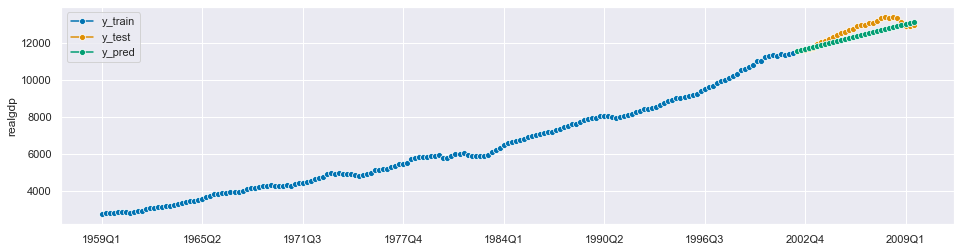

In [46]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **Randomized Search with a scikit-learn estimator**

In [47]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, strategy="recursive")
params = {"window_length": list(range(2, 21))}

In [48]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
frs = ForecastingRandomizedSearchCV(forecaster, strategy="refit", cv=cv, 
                                     param_distributions=params, n_iter=5, random_state=42)

In [49]:
frs.fit(y_train)
y_pred = frs.predict(fh_abs)

In [50]:
frs.best_params_

{'window_length': 2}

In [51]:
frs.best_score_

0.006823426574360506

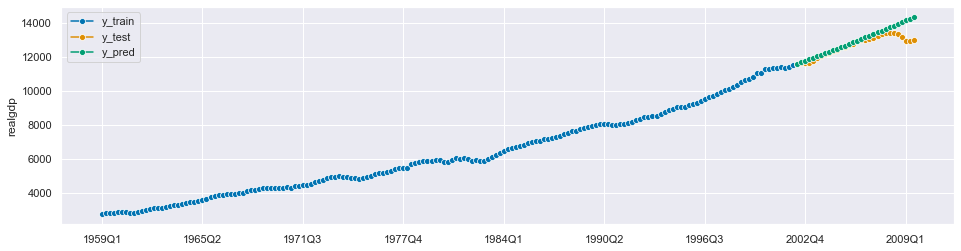

In [52]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **Tuning nested parameters**

Random Forest Regressor

In [53]:
regressor = RandomForestRegressor(n_estimators=20)
forecaster = make_reduction(regressor)

In [54]:
forecaster.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(n_estimators=20),
 'window_length': 10}

In [55]:
nested_params = {"window_length": list(range(2,21)), 
                 "estimator__max_depth": list(range(5,16))}

In [56]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
nrcv = ForecastingRandomizedSearchCV(forecaster, strategy="refit", cv=cv, 
                                     param_distributions=nested_params, 
                                     n_iter = 5, random_state=42)

In [57]:
nrcv.fit(y_train)
y_pred = nrcv.predict(fh_abs)

In [58]:
nrcv.best_params_

{'window_length': 5, 'estimator__max_depth': 8}

In [59]:
nrcv.best_score_

0.013591081093330749

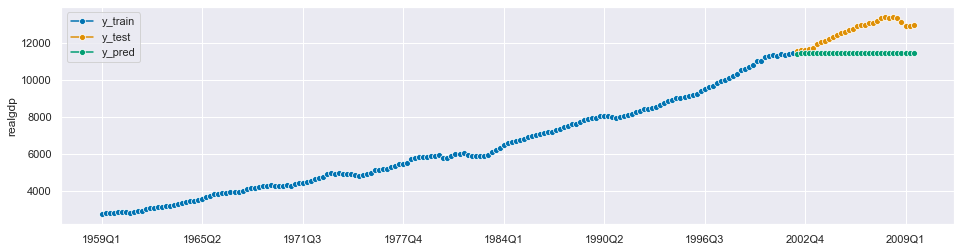

In [60]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## 4. New forecasting functionalities

### Transformers

**Deseasonalizer**

In [61]:
transformer = Deseasonalizer(sp=4) #removing seasonality
y_train_transformed = transformer.fit_transform(y_train)

In [62]:
y_train_inversed = transformer.inverse_transform(y_train_transformed) #inversing the seasonality removal

In [63]:
#after inversing the transformation, values are again on the same scale as they were before
(np.round(y_train.values, 3) == np.round(y_train_inversed.values, 3)).all()

True

**Box-Cox transformation**

In [64]:
forecaster = ThetaForecaster(sp=4)
transformer = BoxCoxTransformer(sp=4) #Box-Cox power transformation
y_train_transformed = transformer.fit_transform(y_train)

In [65]:
forecaster.fit(y_train_transformed)
y_pred = forecaster.predict(fh=fh_abs)
y_pred_inversed = transformer.inverse_transform(y_pred)

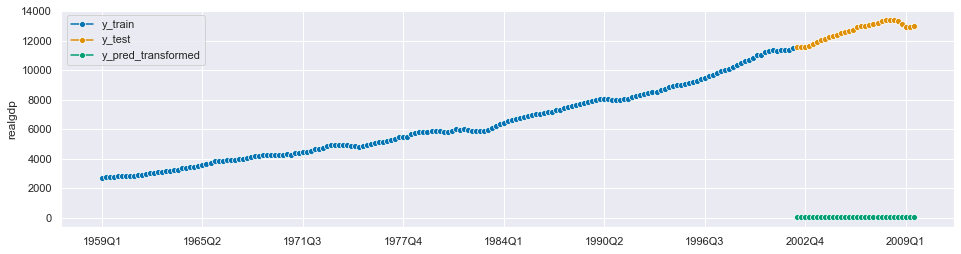

In [66]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred_transformed"]);

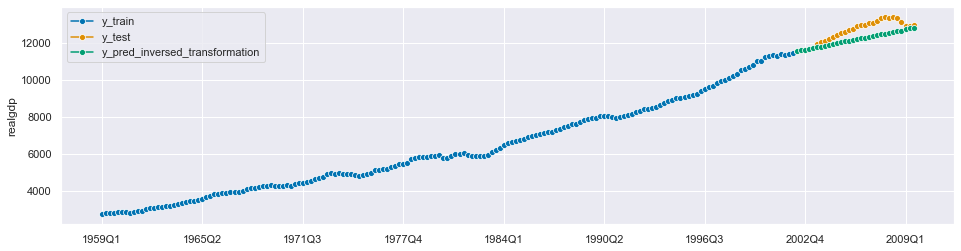

In [67]:
plot_series(y_train, y_test, y_pred_inversed, labels=["y_train", "y_test", "y_pred_inversed_transformation"]);

### Pipelines

- ***TransformedTargetForecaster*** - **simple pipeline**

In [68]:
#two transformers and a forecaster
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(sp=4)),
    ("box_cox", BoxCoxTransformer(sp=4)),    
    ("forecast", ThetaForecaster(sp=4))]
)

In [69]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

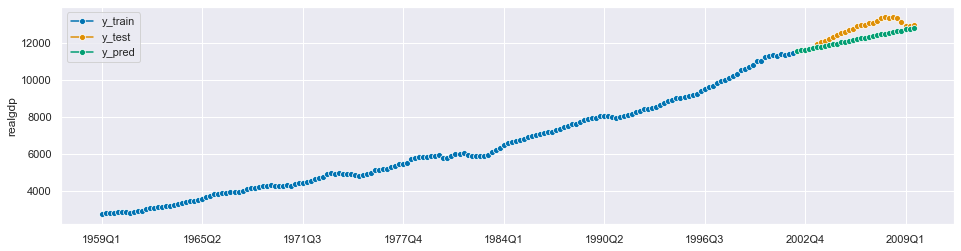

In [70]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- ***ForecastingPipeline*** - **pipeline with exogenous variables**

In [71]:
forecaster = ForecastingPipeline(
    [("hampel", HampelFilter()),
    ("log", LogTransformer()),
    ("forecaster", ThetaForecaster(sp=4))])

In [72]:
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh=fh_abs, X=X_test)

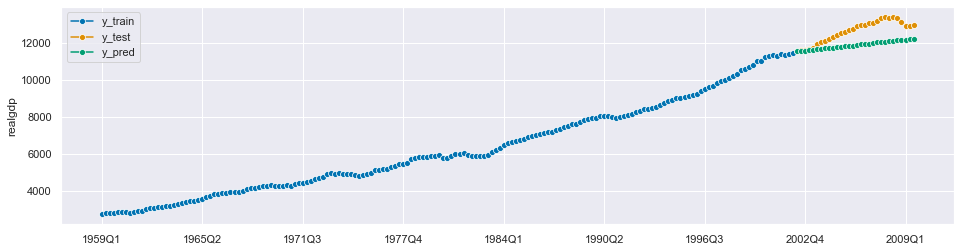

In [73]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Automated model selection

- *****MultiplexForecaster***** - **finding the best forecaster** 

In [74]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("theta", ThetaForecaster(sp=4)),
        ("ets", ExponentialSmoothing(trend="add", sp=4)),
        ("autoarima", AutoARIMA(sp=4)),
    ],
)

In [75]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
forecaster_param_grid = {"selected_forecaster": ["theta", "ets", "autoarima"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [76]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=60, window_length=30),
                        forecaster=MultiplexForecaster(forecasters=[('theta',
                                                                     ThetaForecaster(sp=4)),
                                                                    ('ets',
                                                                     ExponentialSmoothing(sp=4,
                                                                                          trend='add')),
                                                                    ('autoarima',
                                                                     AutoARIMA(sp=4))]),
                        param_grid={'selected_forecaster': ['theta', 'ets',
                                                            'autoarima']})

In [77]:
gscv.best_params_

{'selected_forecaster': 'ets'}

In [78]:
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('theta', ThetaForecaster(sp=4)),
                                 ('ets',
                                  ExponentialSmoothing(sp=4, trend='add')),
                                 ('autoarima', AutoARIMA(sp=4))],
                    selected_forecaster='ets')

- *****OptionalPassthrough***** - **finding the best transformations** 

In [79]:
forecaster = TransformedTargetForecaster([("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
                                          ("forecaster", ExponentialSmoothing())])
forecaster.get_params()

{'steps': [('deseasonalizer',
   OptionalPassthrough(transformer=Deseasonalizer())),
  ('forecaster', ExponentialSmoothing())],
 'deseasonalizer': OptionalPassthrough(transformer=Deseasonalizer()),
 'forecaster': ExponentialSmoothing(),
 'deseasonalizer__passthrough': False,
 'deseasonalizer__transformer__model': 'additive',
 'deseasonalizer__transformer__sp': 1,
 'deseasonalizer__transformer': Deseasonalizer(),
 'forecaster__damped_trend': False,
 'forecaster__initial_level': None,
 'forecaster__initial_seasonal': None,
 'forecaster__initial_trend': None,
 'forecaster__initialization_method': 'estimated',
 'forecaster__seasonal': None,
 'forecaster__sp': None,
 'forecaster__trend': None,
 'forecaster__use_boxcox': None}

In [80]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
params = {"deseasonalizer__passthrough": [True, False],
          "deseasonalizer__transformer__model": ["additive", "multiplicative"]}

gscv = ForecastingGridSearchCV(forecaster=forecaster,
                               param_grid=params,
                               cv=cv)

In [81]:
gscv.fit(y_train)
gscv.best_params_ #model performs better with the transformation

{'deseasonalizer__passthrough': True,
 'deseasonalizer__transformer__model': 'additive'}

### Ensemble forecasting

In [82]:
ensemble = EnsembleForecaster(forecasters = [("tbats", TBATS()),
                                             ("autoarima", AutoARIMA())],                         
                              aggfunc = "min")

In [83]:
ensemble.fit(y_train)
y_pred = ensemble.predict(fh_abs) #averaged predictions of both models

In [84]:
ensemble.forecasters_

[TBATS(), AutoARIMA()]

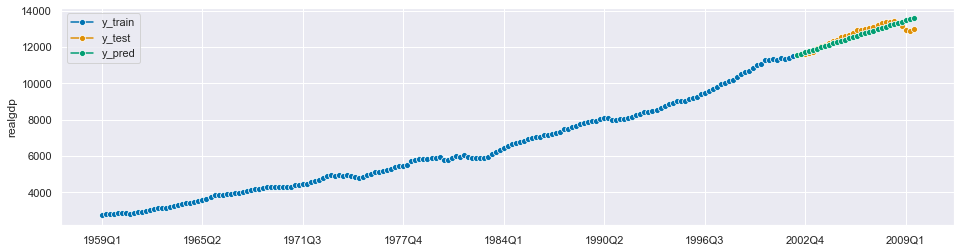

In [85]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);